# dislib hands-on exercise

This notebook includes some exercises to learn the basics of using [dislib](https://dislib.bsc.es).

## Requirements

Apart from dislib, this notebook requires [PyCOMPSs 2.8 or higher](https://www.bsc.es/research-and-development/software-and-apps/software-list/comp-superscalar/).


## Setup


First, we need to start an interactive PyCOMPSs session:

In [1]:
import pycompss.interactive as ipycompss
import os
if 'BINDER_SERVICE_HOST' in os.environ:
    ipycompss.start(graph=True,
                    project_xml='../xml/project.xml',
                    resources_xml='../xml/resources.xml')
else:
    ipycompss.start(graph=True, monitor=1000)

********************************************************
**************** PyCOMPSs Interactive ******************
********************************************************
*          .-~~-.--.           _____      __   ______  *
*         :         )         |____ \    /  | /  __  \ *
*   .~ ~ -.\       /.- ~~ .     ___) |  /_  | | |  | | *
*   >       `.   .'       <    / ___/     | | | |  | | *
*  (         .- -.         )  | |___   _  | | | |__| | *
*   `- -.-~  `- -'  ~-.- -'   |_____| |_| |_| \______/ *
*     (        :        )           _ _ .-:            *
*      ~--.    :    .--~        .-~  .-~  }            *
*          ~-.-^-.-~ \_      .~  .-~   .~              *
*                   \ \ '     \ '_ _ -~                *
*                    \`.\`.    //                      *
*           . - ~ ~-.__\`.\`-.//                       *
*       .-~   . - ~  }~ ~ ~-.~-.                       *
*     .' .-~      .-~       :/~-.~-./:                 *
*    /_~_ _ . - ~              

Next, we import dislib and we are all set to start working!

In [2]:
import dislib as ds

## Machine learning with dislib

Dislib provides an estimator-based API very similar to [scikit-learn](https://scikit-learn.org/stable/). An estimator is anything that learns from data. To illustrate how an estimator works, let's first generate some data:

In [3]:
from sklearn.datasets import make_blobs

x_np, y = make_blobs(n_samples=1500, random_state=170)

`x_np` and `y` are random samples and labels. Samples are vectors and labels are numbers that represent the category of each sample. In this example, we are going to run clustering algorithms, which are useful to understand **unlabeled** data, and thus, we will not use `y`. 

Since the samples in `x_np` are 2-dimensional, we can plot them and see that there are 3 clusters in our data:

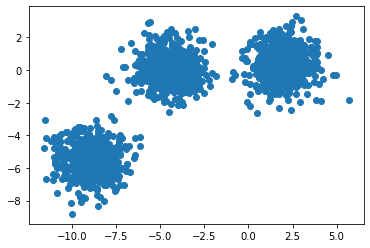

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(x_np[:, 0], x_np[:, 1])

To use dislib, we first need to convert `x` to a ds-array:

In [5]:
x = ds.array(x_np, block_size=(300, 2))
x

ds-array(blocks=(...), top_left_shape=(300, 2), reg_shape=(300, 2), shape=(1500, 2), sparse=False)

## Using DBSCAN

We have seen before the behaviour of K-means. K-means is a simple yet effective clustering method. However, K-means has a major drawback: the number of clusters needs to be defined beforehand. This is no always possible, and other clustering methods have attempted to address this limitation.

An example is DBSCAN, which is a density based clustering algorithm. In DBSCAN, users define density using two parameters: `eps` and `min_samples`. The algorithm then finds an arbitrary number of clusters based on these two parameters.

Your task now is to experiment with different `eps` and `min_samples` values to see how DBSCAN performs with the blob data!

**WARNING:** DBSCAN works a bit different to K-means. You can find its API reference [here](https://dislib.bsc.es/en/stable/dislib.cluster.dbscan.html#dislib.cluster.dbscan.base.DBSCAN):

In [6]:
from dislib.cluster import DBSCAN

# fill in the values for eps and min_samples
dbscan = DBSCAN(eps=1, min_samples=15)

In [7]:
# fit and predict the labels for x
y_pred = dbscan.fit_predict(x)

When you are done, you can plot the results with the following code (assuming predicted labels are in `y_pred`):

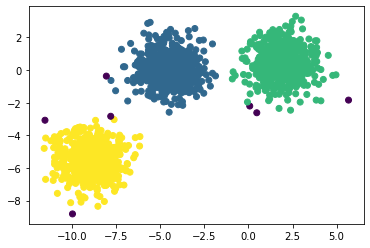

In [8]:
# set the color of each sample to the predicted label
plt.scatter(x_np[:, 0], x_np[:, 1], c=y_pred.collect())

Now let's try with different data.

In [9]:
from sklearn.datasets import make_circles
x_np, _ = make_circles(n_samples=1500, factor=.5, noise=.05, random_state=170)

Use K-means and DBSCAN to cluster the data in x_np. Which algorithm performs better?

In [10]:
# Create ds-array
x = ds.array(x_np, block_size=(300, 2))

from dislib.cluster import KMeans

# Create estimators
kmeans = KMeans(n_clusters=2)
dbscan = DBSCAN(eps=0.1, min_samples=5)

# Fit and predict labels
y_dbscan = dbscan.fit_predict(x)
y_km = kmeans.fit_predict(x)

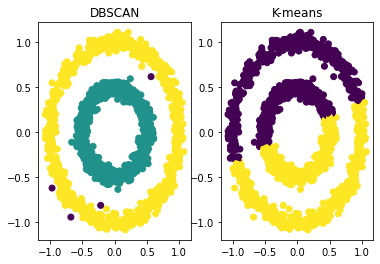

In [11]:
# Use this to plot the results

ax = plt.subplot(121)
ax.title.set_text("DBSCAN")
ax.scatter(x_np[:, 0], x_np[:, 1], c=y_dbscan.collect())
ax = plt.subplot(122)
ax.title.set_text("K-means")
ax.scatter(x_np[:, 0], x_np[:, 1], c=y_km.collect())

## Classification

Now we will solve an exercise using the digits data set from scikit-learn. Samples in this data set represent images of handwritten digits (0 to 9), where each feature represents a pixel in the image.

First, we load the data set:

In [12]:
from sklearn.datasets import load_digits

digits = load_digits()
x_np = digits.data
y = digits.target.reshape(-1, 1)

x_np.shape

(1797, 64)

`x_np` contains 1797 samples of 64 features, and `y` contains the labels, which in this case is the handwritten number.

In [13]:
digit = x_np[23]
digit

array([ 0.,  1.,  8., 12., 15., 14.,  4.,  0.,  0.,  3., 11.,  8.,  8.,
       12., 12.,  0.,  0.,  0.,  0.,  0.,  2., 13.,  7.,  0.,  0.,  0.,
        0.,  2., 15., 12.,  1.,  0.,  0.,  0.,  0.,  0., 13.,  5.,  0.,
        0.,  0.,  0.,  0.,  0.,  9., 13.,  0.,  0.,  0.,  0.,  7.,  8.,
       14., 15.,  0.,  0.,  0.,  0., 14., 15., 11.,  2.,  0.,  0.])

We can see actually see the digit by reshaping the vector and plotting it:

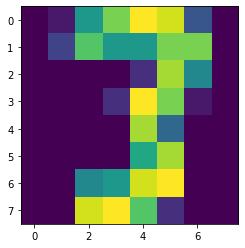

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

digit = digit.reshape((8,8))
plt.imshow(digit)

...and the corresponding label should be a 3:

In [15]:
y[23]

array([3])

Although the original data set has 10 different labels, we can simplify the problem by converting it into a binary classification problem, where odd numbers have label=0 and even numbers have label=1:

In [16]:
y = y%2

Now `y[23]` should be 1:

In [17]:
y[23]

array([1])

Classification is different from clustering in that labels are also used for the fitting process. Once a classifier is fitted, we can use it to label unlabeled data.

To simulate having labeled (training) and unlabeled (test) data, we split the digits data set:

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_np, y)

`x_train` and `x_test` now contain 75% and 25% of the samples in `x` respectively.

Your task is to use `CascadeSVM` and `RandomForestClassifier` to classify the digits data, and get the accuracy obtained!

### Hints:

- You can find dislib's API reference [here](https://dislib.bsc.es/en/stable/api-reference.html).
- Remember to convert data to ds-arrays before passing them to the classifiers.
- Do not worry too much about the classifiers' parameters, you can use the default values.
- Use the train data to fit the estimators, and the test data to check the accuracy.
- Accuracy can be obtained using the `score` method.

In [19]:
# reshaping is needed because of reasons
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# convert your data to ds-arrays
x_ds_train = ds.array(x_train, block_size=(300, 64))
y_ds_train = ds.array(y_train, block_size=(300, 1))

x_ds_test = ds.array(x_test, (300, 64))
y_ds_test = ds.array(y_test, (300, 1))

In [20]:
from dislib.classification import CascadeSVM

# create CascadeSVM estimator
csvm = CascadeSVM(gamma=0.1)


# fit the estimator with training data
csvm.fit(x_ds_train, y_ds_train)


# print the accuracy on the test data
score = csvm.score(x_ds_test, y_ds_test)

from pycompss.api.api import compss_wait_on
print(compss_wait_on(score))


0.5133333333333333


In [21]:
# now do the same as above using the RandomForestClassifier :)

from dislib.classification import RandomForestClassifier


rf = RandomForestClassifier()

rf.fit(x_ds_train, y_ds_train)

print(compss_wait_on(rf.score(x_ds_test, y_ds_test)))




0.9666666666666667


Which classifier gets better results?

## Hyperparameter optimization

Classifiers' performance is highly sensitive to the initialization parameters (or hyperparameters), and it is difficult to know which parameters are optimal beforehand. Thankfully, there are hyperparameter optimization techniques that allow us to find good parameters for our classification problem.

One of these techniques is grid search with cross-validation. This model selection algorithm performs an exhaustive search on a predefined set of hyperparameters to find the optimal ones.

Try to improve the score of the CascadeSVM classifier using grid search! You can find GridSearchCV reference [here](https://dislib.bsc.es/en/latest/dislib.model_selection.html#dislib.model_selection.GridSearchCV).

In [22]:
from dislib.model_selection import GridSearchCV

# hyperparameter search space
params = {"gamma" : (0.1, 0.01, 0.0001), "c" : (1, 10, 100)}

csvm = CascadeSVM()

# use grid search with your training data (it might take a while, be patient)
searcher = GridSearchCV(csvm, params)
searcher.fit(x_ds_train, y_ds_train)



In [23]:
# Use this cell to print the results in a nice way
import pandas as pd
pd.DataFrame(searcher.cv_results_)[["params", "mean_test_score"]]

,params,mean_test_score
0,"{'c': 1, 'gamma': 0.1}",0.479579
1,"{'c': 1, 'gamma': 0.01}",0.897552
2,"{'c': 1, 'gamma': 0.0001}",0.932449
3,"{'c': 10, 'gamma': 0.1}",0.479579
4,"{'c': 10, 'gamma': 0.01}",0.903494
5,"{'c': 10, 'gamma': 0.0001}",0.976236
6,"{'c': 100, 'gamma': 0.1}",0.479579
7,"{'c': 100, 'gamma': 0.01}",0.903494
8,"{'c': 100, 'gamma': 0.0001}",0.985893


Now, try the optimal parameters with the test data:

In [24]:
# Set the optimal parameters here
csvm = CascadeSVM(gamma=0.0001, c=100)

csvm.fit(x_ds_train, y_ds_train)

from pycompss.api.api import compss_wait_on
compss_wait_on(csvm.score(x_ds_test, y_ds_test))

0.9866666666666667

Did the results improve?

## Close the session

To finish the session, we need to stop PyCOMPSs:

In [25]:
ipycompss.stop()

********************************************************
*************** STOPPING PyCOMPSs ******************
********************************************************
Checking if any issue happened.
         have not been brought to the master.
********************************************************
